In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""   # hide all GPUs
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" # (optional) quieter logs

# (optional) tune CPU threads a bit
os.environ["TF_NUM_INTEROP_THREADS"] = "2"
os.environ["TF_NUM_INTRAOP_THREADS"] = "4"

import tensorflow as tf
print(tf.config.list_physical_devices())        # sanity check
print(tf.config.list_physical_devices('GPU'))   # should be []


2025-09-26 17:02:45.819382: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758895365.830661 1082203 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758895365.833904 1082203 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1758895365.842021 1082203 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758895365.842039 1082203 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758895365.842040 1082203 computation_placer.cc:177] computation placer alr

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[]


2025-09-26 17:02:47.436636: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [2]:
import os
from collections import Counter

# sklearn
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# pandas
import pandas as pd

**We do Hamiltonian learning of a 1D chain that has real onsite energy. We predict the Hamiltonian parameters of the real onsite energies of a single site as a function of spectral density of the same site.
This is done by using a neural network with input dimensions equal to the size of the spectral density of one site and output size = 1.
All the data used in this study is theoretically generated using the functions eigensys and ldos.**

**Generating input date, N is the size of the chain, f is the size of the frequency grid, and l is the sample size, these values can be editted in the next cell**

In [ ]:
# Make repo root importable when running from notebooks/
import sys, os
# if you later move the notebook into notebooks/, change "." -> ".."
sys.path.append(os.path.abspath(".."))

from src.physics_utilities import (
    eigensys,          
    diagonalize,
    fidelity,
    ldos,
    ldos_map_from_pred,
    adding_noise,      
    input_data,      
    visualize_HAM,  
)

from src.plots import (
    pred_vs_true,
    ldos_pred_vs_true,
    fidelity_vs_noise_plot,
)

from src.ml_models import (
    create_model,
    create_model_prevent_overfitting,
)

from src.fidelity_vs_noise_study import predict_on_noise


In [5]:
N=8
f=300
l=1000
X, Y = input_data(N,f,l)  #Generating the input for the training and testing
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)  # Split data into train and test data

In [6]:
model = create_model(input_shape=X_train.shape[1:])  #Defining the neural network 
model.compile(optimizer="adam", loss="mse") #compiling

In [7]:
print(model.summary()) #tracking the training and validation loss of the network
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ x_input (InputLayer)            │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 300)            │        90,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 125,501 (490.24 KB)

 Trainable params: 125,501 (490.24 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0707 - val_loss: 0.0194
Epoch 2/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0147 - val_loss: 0.0093
Epoch 3/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0077 - val_loss: 0.0072
Epoch 4/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0046 - val_loss: 0.0051
Epoch 5/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0034 - val_loss: 0.0069
Epoch 6/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - loss: 0.0032 - val_loss: 0.0063
Epoch 7/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 8/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0019 - val_loss: 0.0024
Epoch 9/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0014 - val_loss: 0.0025
Epoch 10/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0014 - val_loss: 0.0039
Epoch 11/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 0.0015 - val_loss: 0.0026
Epoch 12/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s

In [8]:
loss = model.evaluate(X_test, y_test) #the loss between the true and predicted test data
print("Test Loss:", loss)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 7.8943e-04
Test Loss: 0.0006826371536590159


In [9]:
y_pred_test = model.predict(X_test) #prediction of the test data
y_true_test = y_test
print(y_pred_test.shape) #sanity check
print(y_true_test.shape)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step
(1600, 1)
(1600, 1)


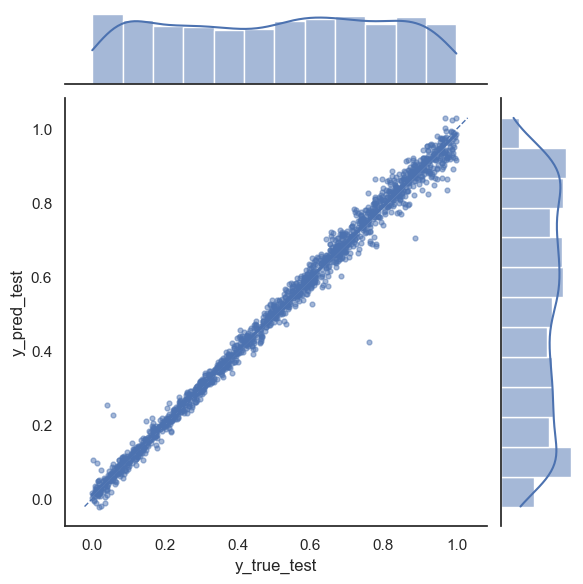

In [10]:
pred_vs_true(y_test,y_pred_test)

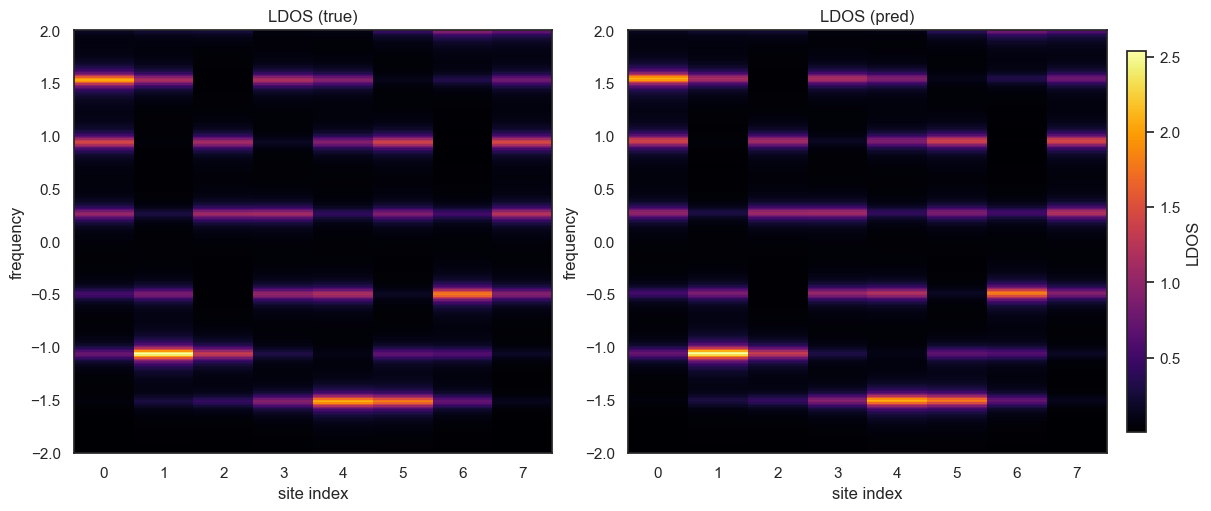

In [11]:
#A visual comparison of the predicted versus the true values, we compute the spectral density 
#of the predicted and true and compare them
  
z_true = ldos_map_from_pred(y_true_test, N=8, f=300,
                                  eigensys=eigensys, ldos=ldos,
                                  col=0, freq_min=-2., freq_max=2.)

z_pred = ldos_map_from_pred(y_pred_test, N=8, f=300,
                                  eigensys=eigensys, ldos=ldos,
                                  col=0, freq_min=-2., freq_max=2.)



x = np.arange(8)
y = freqs                  # length f
ldos_pred_vs_true(x, y, z_true, z_pred, path="results/ldos_true_pred1.png")



**Now we study the robustness of our neural network in the presence of noise, we do this by adding noise obtained from the normal distribution of different strengths (standard deviation of the normal distribution) and study the Fidelity or correlation between the predicted and true values as a function of this noise strangths**

Test Loss (noise_std=0.000): 0.000101
Fidelity for noise_std=0.000: Train (0.9996), Test (0.9995)
Test Loss (noise_std=0.022): 0.000604
Fidelity for noise_std=0.022: Train (0.9973), Test (0.9965)
Test Loss (noise_std=0.044): 0.002000
Fidelity for noise_std=0.044: Train (0.9924), Test (0.9894)
Test Loss (noise_std=0.067): 0.004562
Fidelity for noise_std=0.067: Train (0.9828), Test (0.9736)
Test Loss (noise_std=0.089): 0.007546
Fidelity for noise_std=0.089: Train (0.9770), Test (0.9568)
Test Loss (noise_std=0.111): 0.011529
Fidelity for noise_std=0.111: Train (0.9651), Test (0.9342)
Test Loss (noise_std=0.133): 0.015899
Fidelity for noise_std=0.133: Train (0.9418), Test (0.9127)
Test Loss (noise_std=0.156): 0.020796
Fidelity for noise_std=0.156: Train (0.9688), Test (0.8872)
Test Loss (noise_std=0.178): 0.026839
Fidelity for noise_std=0.178: Train (0.9005), Test (0.8574)
Test Loss (noise_std=0.200): 0.033546
Fidelity for noise_std=0.200: Train (0.9568), Test (0.8336)


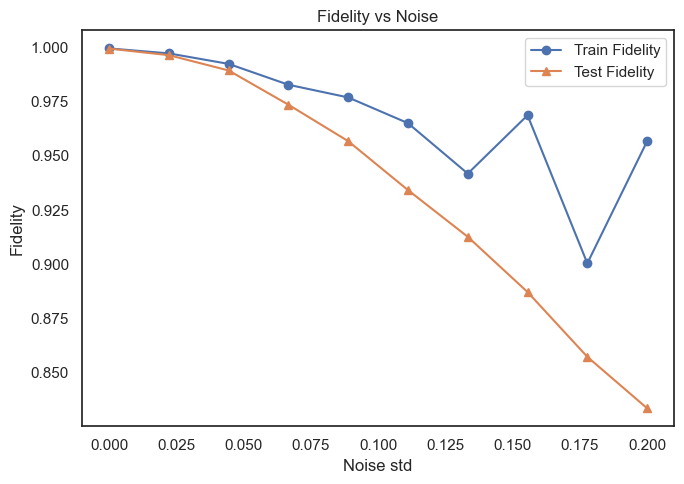

In [13]:
noise_vals, F_tr, F_te,y_pred_test_noise = predict_on_noise(
    0.0, 0.2, X_train, y_train, X_test, y_test,
    n_points=10, epochs=20, batch_size=16,
    create_model=create_model, adding_noise=adding_noise, fidelity=fidelity
)


fidelity_vs_noise_plot(noise_vals, F_tr, F_te,
                       path="results/fidelity_vs_noise.png",
                       title="Fidelity vs Noise")



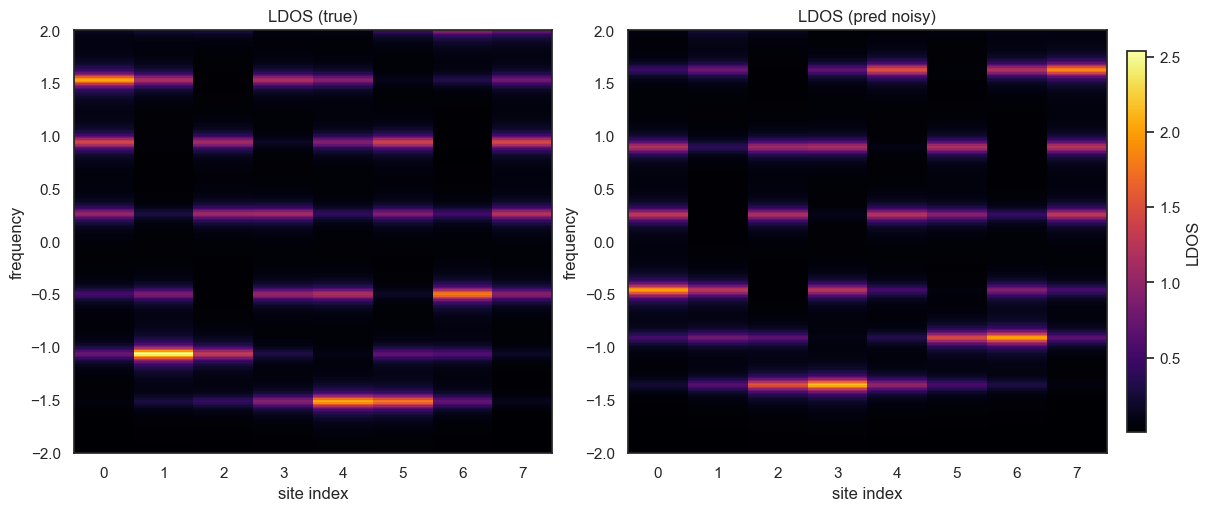

In [14]:
#A visual comparison of the predicted versus the true values, we compute the spectral density 
#of the predicted and true and compare them with noise having noise_std=0.2
 
    
    
z_pred_noisy = ldos_map_from_pred(y_pred_test_noise, N=8, f=300,
                                  eigensys=eigensys, ldos=ldos,
                                  col=0, freq_min=-2., freq_max=2.)


x = np.arange(8)
y = freqs                  # length f
ldos_pred_vs_true(x, y, z_true, z_pred, path="results/ldos_true_pred_noisy_with_overfitting.png")



**We studied the robustness of our neural network in the presence of noise, but there was an overfitting of our network towards training date, we try to combat this overfitting by twicking the neural network, we do this by adding dropout layers.**

Test Loss (noise_std=0.000): 0.007502
Fidelity for noise_std=0.000: Train (0.9847), Test (0.9852)
Test Loss (noise_std=0.022): 0.006833
Fidelity for noise_std=0.022: Train (0.9843), Test (0.9856)
Test Loss (noise_std=0.044): 0.007742
Fidelity for noise_std=0.044: Train (0.9823), Test (0.9841)
Test Loss (noise_std=0.067): 0.009615
Fidelity for noise_std=0.067: Train (0.9702), Test (0.9702)
Test Loss (noise_std=0.089): 0.012718
Fidelity for noise_std=0.089: Train (0.9541), Test (0.9547)
Test Loss (noise_std=0.111): 0.014750
Fidelity for noise_std=0.111: Train (0.9456), Test (0.9462)
Test Loss (noise_std=0.133): 0.019907
Fidelity for noise_std=0.133: Train (0.9238), Test (0.9241)
Test Loss (noise_std=0.156): 0.025113
Fidelity for noise_std=0.156: Train (0.9007), Test (0.8946)
Test Loss (noise_std=0.178): 0.030380
Fidelity for noise_std=0.178: Train (0.8824), Test (0.8753)
Test Loss (noise_std=0.200): 0.037048
Fidelity for noise_std=0.200: Train (0.8674), Test (0.8562)


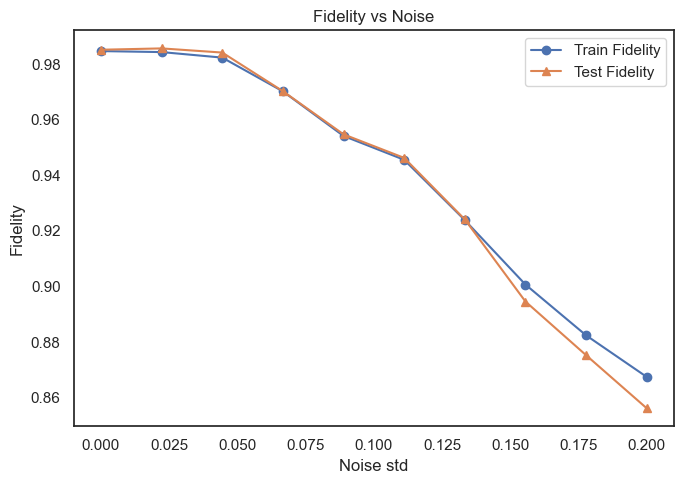

In [16]:
noise_vals, F_tr1, F_te1,y_pred_test_noise1 = predict_on_noise(
    0.0, 0.2, X_train, y_train, X_test, y_test,
    n_points=10, epochs=20, batch_size=16,
    create_model=create_model_prevent_overfitting, adding_noise=adding_noise, fidelity=fidelity
)

    
fidelity_vs_noise_plot(noise_vals, F_tr1, F_te1,
                       path="results/fidelity_vs_noise_nooverfitting.png",
                       title="Fidelity vs Noise")



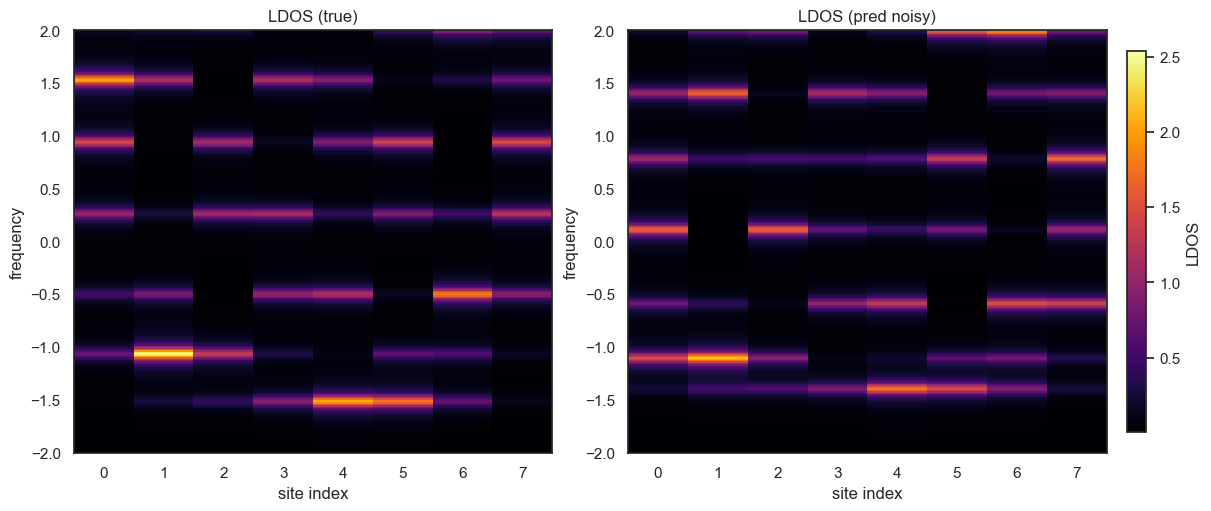

In [17]:
#A visual comparison of the predicted versus the true values, we compute the spectral density 
#of the predicted and true and compare them with noise having noise_std=0.2

    
z_pred_noisy1 = ldos_map_from_pred(y_pred_test_noise1, N=8, f=300,
                                  eigensys=eigensys, ldos=ldos,
                                  col=0, freq_min=-2., freq_max=2.)

x = np.arange(8)
y = freqs                  # length f
ldos_pred_vs_true(x, y, z_true, z_pred_noisy1, path="results/ldos_true_pred_noisy_nooverfitting.png")
  

**The end**